In [2]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams["figure.figsize"]=(6,4)
rcParams["figure.dpi"]=120


In [3]:
%load_ext autoreload
%autoreload 2

# Data Generation

Let's generate a noisy sine function with amplitude `A` and wave number `k`. The first step is to prepare the model using the true parameters.


In [4]:
def sin(x, A, k):
    """Return a sine function with amplitude A and wavenumber k"""
    return A * np.sin(k * x)

In [5]:
A_true = 5
k_true = 2

x_true = np.linspace(0, 10, 100)
y_true = sin(x_true, A_true, k_true)

Now we add some noise on top to emulate an observation. 

In [6]:
def add_noise_to(y, sigma):
    """Add random gaussian noise with amplitude sigma to the input y"""
    
    y_noise = sigma * np.random.randn(len(y))
    
    return y + y_noise

In [7]:
sigma_noise = 0.5
x_obs = x_true
y_obs = add_noise_to(y_true, sigma_noise)

Let's see what this looks like

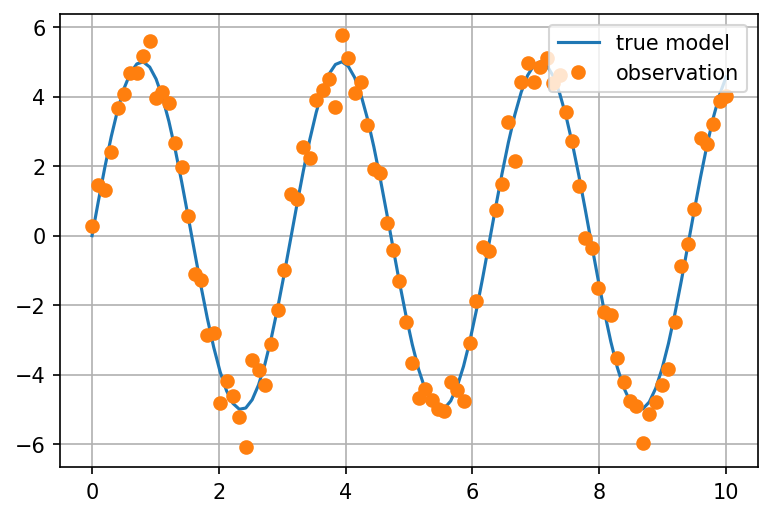

In [8]:
plt.figure(figsize=(6,4), dpi=150)
plt.plot(x_true, y_true, label="true model")
plt.plot(x_obs, y_obs, "o", label="observation")

plt.legend(loc=1)
plt.grid()

Great!

# Inference

## Priors

Now let's try to infer the model parameters `A`, `k`, as well as the noisi parameter `sigma_noise`.

In [9]:
with pm.Model() as model:
    
    # priors
    A = pm.Uniform("A", lower=0, upper=10)  # P(A)
    k = pm.Uniform("k", lower=0.5, upper=5)  # P(k)
    
    sigma_n = pm.HalfNormal("sigma_n", sigma=1)  # P(sigma)
    
    y = sin(x_obs, A, k)


Let's stop here and see what the priors look like

In [10]:
with model:
    # sampling
    prior_trace = pm.sample(10000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_n, k, A]
Sampling 2 chains, 12 divergences: 100%|██████████| 21000/21000 [00:14<00:00, 1427.00draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e168f28>,
      dtype=object)

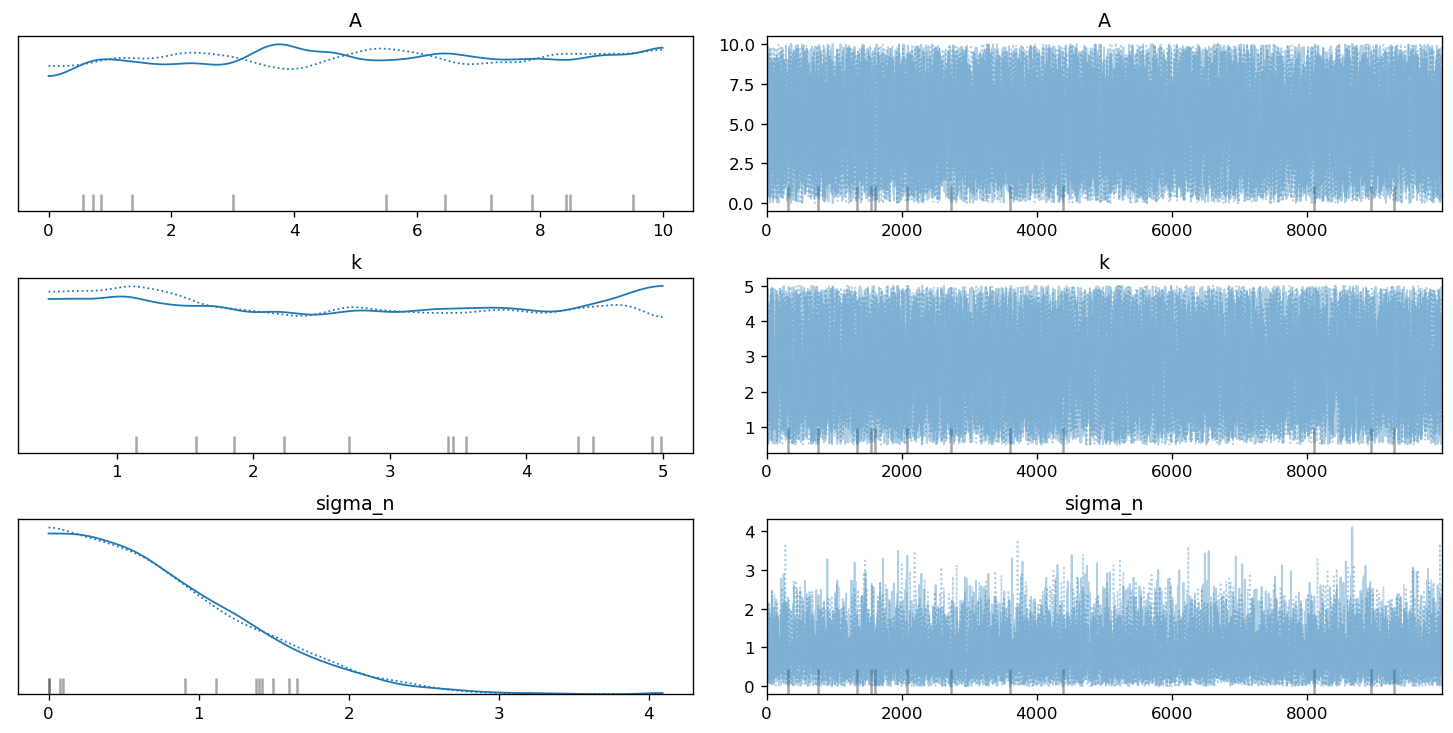

In [11]:
pm.traceplot(prior_trace)

## Posteriors

In [13]:
with model:
    # Likelihood               P(data:y_obs | model: y(A,k), sigma)
    y_lkl = pm.Normal("y_obs", observed=y_obs, mu=y, sigma=sigma_n, )
    
    # sampling
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_n, k, A]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [01:01<00:00, 339.36draws/s] 
The acceptance probability does not match the target. It is 0.9987196144785729, but should be close to 0.8. Try to increase the number of tuning steps.


Now let's check out how the likelihood has constrained the posterior. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1233ac9b0>,
      dtype=object)

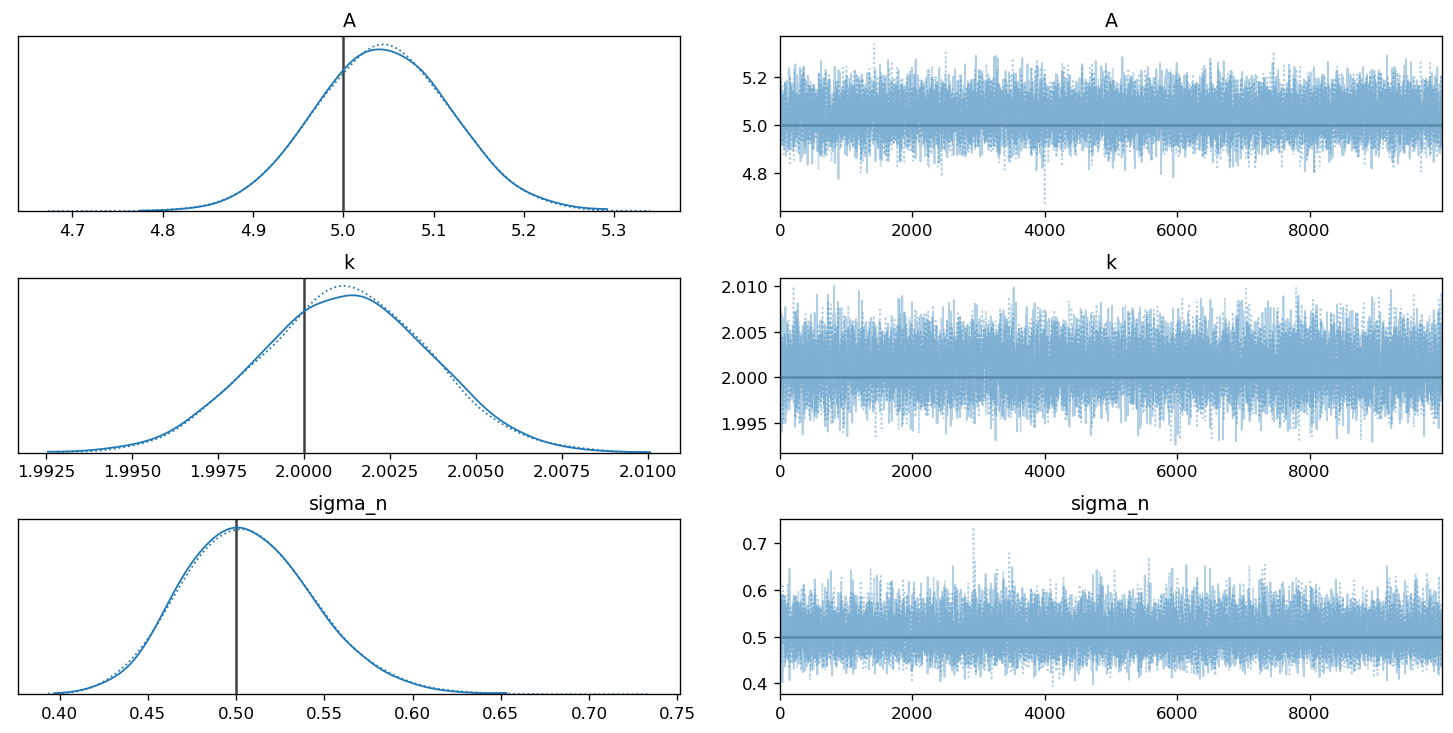

In [14]:
lines = [("A", {}, [A_true]), ("k", {}, [k_true]), ("sigma_n", {}, [sigma_noise])]
pm.traceplot(trace, lines=lines)

In [15]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
A,5.044,0.074,4.908,5.185,0.001,0.0,15744.0,15744.0,15749.0,13015.0,1.0
k,2.001,0.002,1.997,2.006,0.000,0.0,17653.0,17653.0,17651.0,13651.0,1.0
sigma_n,0.508,0.037,0.440,0.577,0.000,0.0,17120.0,17091.0,17174.0,13562.0,1.0


The inferred values are pretty close the the true model parameters! 

# Contour Plots a.k.a Triangle Plots 

## getdist

In [16]:
from getdist import MCSamples, plots

In [17]:
samples = MCSamples(samples= [trace["A"], trace["k"], trace["sigma_n"]],
                    names=["A", "k", r"$\sigma_n$"])

Removed no burn in


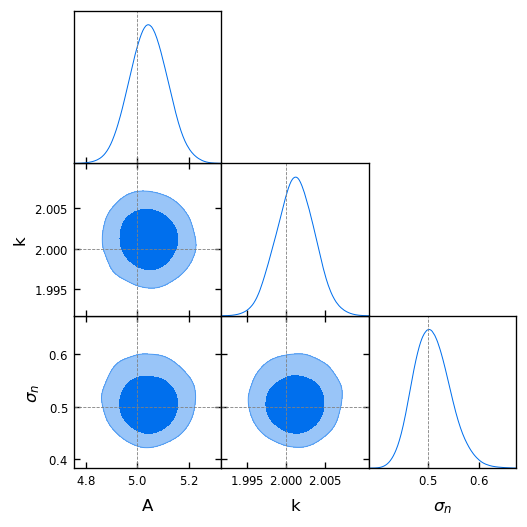

In [18]:
g = plots.getSubplotPlotter(subplot_size=1.5)


g.triangle_plot(samples,
                filled=True,
                markers={"A": A_true,
                         "k": k_true,
                         r"$\sigma_n$": sigma_noise}
               )

## pygtc

In [19]:
import pygtc

In [20]:
names = ["A",
         "k",
         r"$\sigma_n$",
         ]

chains = np.array([trace["A"], trace["k"], trace["sigma_n"],])

/Users/siavashyasini/anaconda3/envs/cosmolab/lib/python3.7/site-packages/pygtc/pygtc.py:1053: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  normed=True, bins=nBins)


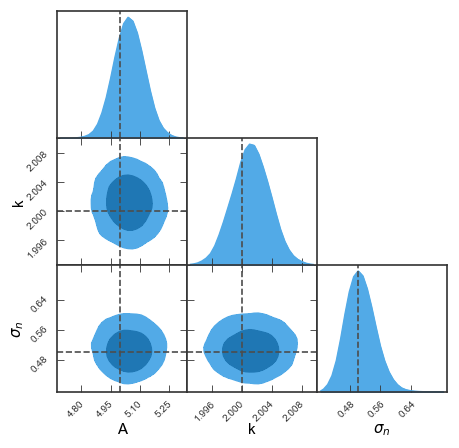

In [21]:
GTC = pygtc.plotGTC(chains=chains.T,
                    paramNames=names,
                    figureSize='MNRAS_page',
                    truths=(A_true, k_true, sigma_noise)
                    )